# Experiment Overview: Free Trial Screener

### Context

At the time of this experiment, Udacity courses currently have two options on the course overview page: "start free trial", and "access course materials". If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. This screenshot shows what the experiment looks like.

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

The unit of diversion is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

# 1.Experiment Design

### 1.1 Metric Choice

Understand Customer Funnel

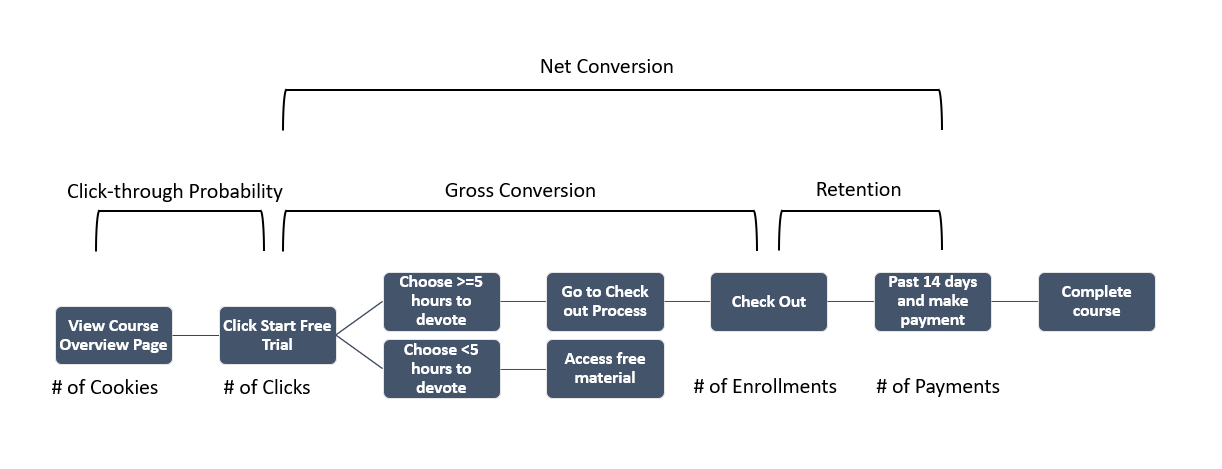

<b>Invariant Metrics:<br>
number of cookies<br>
number of clicks<br>
click-through-probability

<b>Variant Metrics:<br>
Gross Conversion<br>
Retention<br>
Net Conversion

### 1.2 Measuring Standard Deviation

In [201]:
import pandas as pd
import numpy as np
import math
from scipy import stats

In [128]:
baseline=pd.read_csv('D:\AB\Final Project Baseline Values - Sheet1.csv',header=None)

In [129]:
baseline

,0,1
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [130]:
number_of_view=baseline.iloc[0,1]
number_of_click=baseline.iloc[1,1]
number_of_enroll=baseline.iloc[2,1]
gross_conversion=baseline.iloc[4,1]
retention=baseline.iloc[5,1]
net_conversion=baseline.iloc[6,1]

In [131]:
sample_size_view=5000
sample_size_click=number_of_click/number_of_view*sample_size_view
sample_size_enroll=number_of_enroll/number_of_view*sample_size_view

In [132]:
#calculating SE
SE_gross_conversion=math.sqrt(gross_conversion*(1-gross_conversion)/sample_size_click)
SE_retention=math.sqrt(retention*(1-retention)/sample_size_enroll)
SE_net_conversion=math.sqrt(net_conversion*(1-net_conversion)/sample_size_click)

In [133]:
print('SE_gross_conversion:{:.4f}'.format(SE_gross_conversion))
print('SE_retention:{:.4f}'.format(SE_retention))
print('SE_net_conversion:{:.4f}'.format(SE_net_conversion))

SE_gross_conversion:0.0202
SE_retention:0.0549
SE_net_conversion:0.0156


### 1.3 Sizing

<b >1.3.1 Number of Samples<b>

Calculate the size: https://www.evanmiller.org/ab-testing/sample-size.html

Gross conversion

In [134]:
gross_conversion_clicks=25835

In [135]:
gross_conversion_pageviews=round(np.multiply(number_of_view/number_of_click,gross_conversion_clicks),0)
gross_overall_pageviews=gross_conversion_pageviews*2  #control group and experiment group

In [136]:
print(gross_overall_pageviews)

645876.0


Retention

In [137]:
retention_enrolls=39115 

In [138]:
retention_pageviews=round(np.multiply(number_of_view/number_of_enroll,retention_enrolls),0)
retention_overall_pageviews=retention_pageviews*2

In [139]:
print(retention_overall_pageviews)

4741212.0


Net conversion

In [140]:
net_conversion_clicks=27413

In [141]:
net_conversion_page=round(np.multiply(number_of_view/number_of_click,net_conversion_clicks),0)
net_overall_pageviews=net_conversion_page*2

In [142]:
print(net_overall_pageviews)

685324.0


In [143]:
#number of pageviews needed
pageview=max(gross_overall_pageviews,retention_overall_pageviews,net_overall_pageviews)
print('number of pageviews needed {}'.format(pageview))

number of pageviews needed 4741212.0


<b>1.3.2 Duration<b>

In [221]:
traffic_fraction=0.5
duration=pageview/(number_of_view*traffic_fraction)
print('Assume traffic fraction=',traffic_fraction,' Duration of the experiment {}'.format(round(duration,0)))

Assume traffic fraction= 0.5  Duration of the experiment 237.0


237 days are too long for AB testing <br>
We will lower down the number of pageviews needed

In [222]:
duration_2=round(net_overall_pageviews/(number_of_view*traffic_fraction),0)
print('change the duration to {}'.format(duration_2))

change the duration to 34.0


# Experiment Analysis

### Sanity Checks

In [146]:
control=pd.read_excel('D:\AB\Final Project Results.xlsx',sheet_name='Control')

In [147]:
exp=pd.read_excel('D:\AB\Final Project Results.xlsx',sheet_name='Experiment')

In [148]:
total={
    'control':pd.Series([control.sum()['Pageviews'],control.sum()['Clicks'],control.sum()['Enrollments'],control.sum()['Payments']],
                       index=['Pageviews','Clicks','Enrollments','Payments']),
    'exp':pd.Series([exp.sum()['Pageviews'],exp.sum()['Clicks'],exp.sum()['Enrollments'],exp.sum()['Payments']],
                   index=['Pageviews','Clicks','Enrollments','Payments'])
}
total=pd.DataFrame(data=total)

In [149]:
total['total']=total['control']+total['exp']

In [150]:
total['p_hat']=0.5
total['ME']=1.96*np.sqrt(total['p_hat']*(1-total['p_hat'])/total['total'])
total['lower_CI']=total['p_hat']-total['ME']
total['upper_CI']=total['p_hat']+total['ME']
total['observed']=total['control']/(total['exp']+total['control'])

In [151]:
total['sanity_check']=(total['observed']<total['upper_CI'])*(total['observed']>total['lower_CI'])

In [152]:
total.head()
#check pageviews,clicks,enrollments and payments

,control,exp,total,p_hat,ME,lower_CI,upper_CI,observed,sanity_check
Pageviews,345543.0,344660.0,690203.0,0.5,0.001180,0.498820,0.501180,0.500640,True
Clicks,28378.0,28325.0,56703.0,0.5,0.004116,0.495884,0.504116,0.500467,True
Enrollments,3785.0,3423.0,7208.0,0.5,0.011543,0.488457,0.511543,0.525111,False
Payments,2033.0,1945.0,3978.0,0.5,0.015538,0.484462,0.515538,0.511061,True


In [153]:
CT_total=(control['Clicks'].sum()+exp['Clicks'].sum())/(control['Pageviews'].sum()+exp['Pageviews'].sum())

In [154]:
CT_SE=np.sqrt(CT_total*(1-CT_total)*(1/control['Pageviews'].sum()+1/exp['Pageviews'].sum()))

In [155]:
CT_ME=1.96*CT_SE
CT_mean=control['Clicks'].sum()/control['Pageviews'].sum()-exp['Clicks'].sum()/exp['Pageviews'].sum()

In [158]:
print('lower_CI',round(0-CT_ME,4))
print('upper_CI',round(0+CT_ME,4))

lower_CI -0.0013
upper_CI 0.0013


In [ ]:
#click-through rate sanity check true

### Check for Practical and Statistical Significance

<b>Effective Size Test<b>

In [168]:
#gross conversion
n=control['Enrollments'].count()
GC_total=(control['Enrollments'].sum()+exp['Enrollments'].sum())/(control['Clicks'][:n].sum()+exp['Clicks'][:n].sum())
GC_SE=np.sqrt(GC_total*(1-GC_total)*(1/control['Clicks'][:n].sum()+1/exp['Clicks'][:n].sum()))
GC_ME=1.96*GC_SE
GC_mean=exp['Enrollments'].sum()/exp['Clicks'][:n].sum()-control['Enrollments'].sum()/control['Clicks'][:n].sum()

In [169]:
GC_upper_CI=GC_mean+GC_ME
GC_lower_CI=GC_mean-GC_ME
GC_dmin=0.01
print('GC_lower_CI,GC_upper_CI:',round(GC_lower_CI,4),round(GC_upper_CI,4))

GC_lower_CI,GC_upper_CI: -0.0291 -0.012


In [172]:
print('Gross conversion Statistically Significant:',(GC_lower_CI>0)+(GC_upper_CI<0))
print('Gross conversion Practically Significant:',(GC_lower_CI>GC_dmin)+(GC_upper_CI<-GC_dmin))

Gross conversion Statistically Significant: True
Gross conversion Practically Significant: True


In [185]:
#retention
r_total=(control['Payments'].sum()+exp['Payments'].sum())/(control['Enrollments'].sum()+exp['Enrollments'].sum())
r_SE=np.sqrt(r_total*(1-r_total)*(1/control['Enrollments'].sum()+1/exp['Enrollments'].sum()))
r_ME=1.96*r_SE
r_mean=exp['Payments'].sum()/exp['Enrollments'].sum()-control['Payments'].sum()/control['Enrollments'].sum()

In [186]:
r_upper_CI=r_mean+r_ME
r_lower_CI=r_mean-r_ME
r_dmin=0.01
print('r_lower_CI,r_upper_CI:',round(r_lower_CI,4),round(r_upper_CI,4))

r_lower_CI,r_upper_CI: 0.0081 0.0541


In [187]:
print('Retention Statistically Significant:',(r_lower_CI>0)+(r_upper_CI<0))
print('Retention Practically Significant:',(r_lower_CI>GC_dmin)+(r_upper_CI<-r_dmin))

Retention Statistically Significant: True
Retention Practically Significant: False


In [188]:
#Net conversion
NC_total=(control['Payments'].sum()+exp['Payments'].sum())/(control['Clicks'][:n].sum()+exp['Clicks'][:n].sum())
NC_SE=np.sqrt(NC_total*(1-NC_total)*(1/control['Clicks'][:n].sum()+1/exp['Clicks'][:n].sum()))
NC_ME=1.96*NC_SE
NC_mean=exp['Payments'].sum()/exp['Clicks'][:n].sum()-control['Payments'].sum()/control['Clicks'][:n].sum()

In [189]:
NC_upper_CI=NC_mean+NC_ME
NC_lower_CI=NC_mean-NC_ME
NC_dmin=0.01
print('NC_lower_CI,NC_upper_CI:',round(NC_lower_CI,4),round(NC_upper_CI,4))

NC_lower_CI,NC_upper_CI: -0.0116 0.0019


In [190]:
print('Net Conversion Statistically Significant:',(NC_lower_CI>0)+(NC_upper_CI<0))
print('Net Conversion Practically Significant:',(NC_lower_CI>NC_dmin)+(NC_upper_CI<-NC_dmin))

Net Conversion Statistically Significant: False
Net Conversion Practically Significant: False


### Sign Test

In [196]:
Metrics={
    'GC_exp':exp['Enrollments']/exp['Clicks'],
    'GC_control':control['Enrollments']/control['Clicks'],
    'r_exp':exp['Payments']/exp['Enrollments'],
    'r_control':control['Payments']/control['Enrollments'],
    'NC_exp':exp['Payments']/exp['Clicks'],
    'NC_control':control['Payments']/control['Clicks']
}

In [197]:
Metrics=pd.DataFrame(data=Metrics)

In [198]:
Metrics=Metrics.dropna()

In [199]:
Metrics

,GC_exp,GC_control,r_exp,r_control,NC_exp,NC_control
0,0.153061,0.195051,0.323810,0.522388,0.049563,0.101892
1,0.147771,0.188703,0.784483,0.476190,0.115924,0.089859
2,0.164027,0.183718,0.544828,0.568862,0.089367,0.104510
3,0.166868,0.186603,0.666667,0.673077,0.111245,0.125598
4,0.168269,0.194743,0.671429,0.392638,0.112981,0.076464
5,0.163706,0.167679,0.472868,0.594203,0.077411,0.099635
6,0.162821,0.195187,0.346457,0.520548,0.056410,0.101604
7,0.144172,0.174051,0.659574,0.636364,0.095092,0.110759
8,0.172166,0.189580,0.641667,0.458015,0.110473,0.086831
9,0.177907,0.191638,0.640523,0.587879,0.113953,0.112660


In [200]:
p_hat=0.5
alpha=0.05

In [202]:
#gross conversion
GC_positive=sum(Metrics['GC_exp']>Metrics['GC_control'])

In [206]:
GC_pvalue=stats.binom_test(GC_positive,n=23,p=p_hat)

In [214]:
print('Gross Conversion p-value:',GC_pvalue)
print('Gross Conversion Statistically Significant:',GC_pvalue<=alpha)

Gross Conversion p-value: 0.002599477767944336
Gross Conversion Statistically Significant: True


In [208]:
#retention
r_positive=sum(Metrics['r_exp']>Metrics['r_control'])

In [209]:
r_pvalue=stats.binom_test(r_positive,n=23,p=p_hat)

In [215]:
print('Retention p-value:',r_pvalue)
print('Retention Statistically Significant:',r_pvalue<=alpha)

Retention p-value: 0.6776394844055176
Retention Statistically Significant: False


In [211]:
#Net conversion
NC_positive=sum(Metrics['NC_exp']>Metrics['NC_control'])

In [212]:
NC_pvalue=stats.binom_test(NC_positive,n=23,p=p_hat)

In [216]:
print('Net Conversion p-value:',NC_pvalue)
print('Net Conversion Statistically Significant:',NC_pvalue<=alpha)

Net Conversion p-value: 0.6776394844055176
Net Conversion Statistically Significant: False


# Recommendation

### Not To Launch